In [1]:
! pip install pytorch-lightning --quiet
! pip install pytorch-lightning-bolts --quiet
!pip install --upgrade omegaconf

     |████████████████████████████████| 808kB 7.4MB/s 
     |████████████████████████████████| 112kB 15.8MB/s 
     |████████████████████████████████| 276kB 15.8MB/s 
     |████████████████████████████████| 829kB 22.5MB/s 
     |████████████████████████████████| 645kB 36.5MB/s 
     |████████████████████████████████| 1.3MB 52.3MB/s 
     |████████████████████████████████| 296kB 52.8MB/s 
     |████████████████████████████████| 143kB 50.0MB/s 
     |████████████████████████████████| 256kB 7.1MB/s 


In [2]:
import os
import platform

import numpy as np

from omegaconf import OmegaConf

import torch
import pytorch_lightning as pl
from pytorch_lightning.metrics.functional import accuracy

from torchvision.datasets import MNIST
from torchvision import transforms as transform_lib
from torch import nn
from torch.nn import functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split

from tqdm.auto import tqdm

from typing import Optional, Tuple, Any

import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
plt.style.use("dark_background")

In [3]:
class MNISTRandAdder(MNIST):
    """
    A modified version of MNIST
    It adds a random number along with the mnist image, and the target now is
        the mnist image's target + the random number
    For example:
        [MNIST Image for 1], 5 => 1, 6

    Usage:
    >>> MNISTRandAdder = MNISTRandAdder(root='data')
    >>> dloader = DataLoader(MNISTRandAdder)
    >>> batch = next(iter(dloader))
    """

    def __init__(
            self,
            *args,
            **kwargs
    ) -> None:
        super(MNISTRandAdder, self).__init__(*args, **kwargs)

    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        img, target = super(self.__class__, self).__getitem__(index)
        random_number = np.random.randint(low=0, high=10)

        return (img, random_number), (target, target + random_number)

In [4]:
class MNISTRandAdderDataModule(pl.LightningDataModule):
    """
    DataModule for MNISTRandAdder, train, val, test splits and transforms
    >>> MNISTRandAdderDataModule()  # doctest: +ELLIPSIS
    <...MNISTRandAdderDataModule object at ...>
    """

    name = "mnist"

    def __init__(
        self,
        data_dir: str = '.',
        val_split: int = 5000,
        num_workers: int = 2,
        normalize: bool = False,
        seed: int = 42,
        batch_size: int = 32,
        *args,
        **kwargs,
    ):
        """
        Args:
            data_dir: where to save/load the data
            val_split: how many of the training images to use for the validation split
            num_workers: how many workers to use for loading data
            normalize: If true applies image normalize
            seed: starting seed for RNG.
            batch_size: desired batch size.
        """
        super().__init__(*args, **kwargs)
        if num_workers and platform.system() == "Windows":
            # see: https://stackoverflow.com/a/59680818
            warn(
                f"You have requested num_workers={num_workers} on Windows,"
                " but currently recommended is 0, so we set it for you"
            )
            num_workers = 0

        self.dims = (1, 28, 28)
        self.data_dir = data_dir
        self.val_split = val_split
        self.num_workers = num_workers
        self.normalize = normalize
        self.seed = seed
        self.batch_size = batch_size
        self.dataset_train = ...
        self.dataset_val = ...
        self.test_transforms = self.default_transforms

        self.MNIST = MNISTRandAdder

    @property
    def num_classes(self):
        return 10

    def prepare_data(self):
        """Saves MNIST files to `data_dir`"""
        self.MNIST(self.data_dir, train=True, download=True)
        self.MNIST(self.data_dir, train=False, download=True)

    def setup(self, stage: Optional[str] = None):
        """Split the train and valid dataset"""
        extra = dict(transform=self.default_transforms) if self.default_transforms else {}
        dataset = self.MNIST(self.data_dir, train=True, download=False, **extra)
        train_length = len(dataset)
        self.dataset_train, self.dataset_val = random_split(dataset, [train_length - self.val_split, self.val_split])

    def train_dataloader(self):
        """MNIST train set removes a subset to use for validation"""
        loader = DataLoader(
            self.dataset_train,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=self.num_workers,
            drop_last=True,
            pin_memory=True,
        )
        return loader

    def val_dataloader(self):
        """MNIST val set uses a subset of the training set for validation"""
        loader = DataLoader(
            self.dataset_val,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            drop_last=True,
            pin_memory=True,
        )
        return loader

    def test_dataloader(self):
        """MNIST test set uses the test split"""
        extra = dict(transform=self.test_transforms) if self.test_transforms else {}
        dataset = self.MNIST(self.data_dir, train=False, download=False, **extra)
        loader = DataLoader(
            dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            drop_last=True,
            pin_memory=True,
        )
        return loader

    @property
    def default_transforms(self):
        if self.normalize:
            mnist_transforms = transform_lib.Compose([
                transform_lib.ToTensor(), transform_lib.Normalize(mean=(0.5, ), std=(0.5, ))
            ])
        else:
            mnist_transforms = transform_lib.ToTensor()

        return mnist_transforms

In [5]:
class MNISTModel(nn.Module):
    """
    A Basic model for MNIST Digit classification
    INPUT: 1x28x28
    OUTPUT: 28
    """
    def __init__(self):
        super(__class__, self).__init__()

        dropout_value = 0.1

        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=14, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(14),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=30, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(30),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=30, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=14, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(14),
            nn.Dropout(dropout_value)
        ) # output_size = 10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=15, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(15),
            nn.Dropout(dropout_value)
        ) # output_size = 8
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=15, out_channels=15, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(15),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=15, out_channels=20, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(20),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        )

        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.gap(x)        
        x = self.convblock8(x)

        x = x.view(-1, 20)

        return x

In [6]:
class MNISTRandAdderModel(pl.LightningModule):

    def __init__(self, hparams, *args, **kwargs):
        super(MNISTRandAdderModel, self).__init__()

        self.save_hyperparameters(hparams)

        self.num_classes = 10
        self.dims = (1, 28, 28)

        dropout_value = self.hparams.dropout_value
        
        # IN: 1x28x28; OUT: 20
        self.mnist_base = MNISTModel()

        # IN: 30 (20 mnist + 10 OHE rand num)
        self.prefinal_layer1 = nn.Sequential(
            nn.Linear(in_features=30, out_features=60, bias=False),
            nn.BatchNorm1d(60),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        )

        self.prefinal_layer2 = nn.Sequential(
            nn.Linear(in_features=60, out_features=60, bias=False),
            nn.BatchNorm1d(60),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        )

        # IN: 60 ; OUT: 10
        self.mnist_final_layer = nn.Sequential(
            nn.Linear(in_features=60, out_features=10, bias=False),
        )

        # IN: 60 ; OUT 19
        self.adder_final_layer = nn.Sequential(
            nn.Linear(in_features=60, out_features=19, bias=False)
        )

        self.loss = nn.CrossEntropyLoss()

    def forward(self, mnist_img, rand_num):
        rand_num = F.one_hot(rand_num, num_classes=self.num_classes)
        
        # mnist embedding: 1x20
        mnist_embed = self.mnist_base(mnist_img)

        # concat the mnist embedding and the random number = 30 features
        ccat = torch.cat([mnist_embed, rand_num], dim=-1)

        pre_out = self.prefinal_layer1(ccat)
        pre_out = self.prefinal_layer2(pre_out)

        mnist_out = self.mnist_final_layer(pre_out)
        adder_out = self.adder_final_layer(pre_out)

        return mnist_out, adder_out

    def training_step(self, batch, batch_idx):
        (mnist_img, rand_num), (mnist_y, adder_y) = batch

        mnist_pred, adder_pred = self(mnist_img, rand_num)

        # both mnist and adder use cross entropy loss
        mnist_loss = self.loss(mnist_pred, mnist_y)
        adder_loss = self.loss(adder_pred, adder_y)

        # final loss is sum of the two loss
        loss = mnist_loss + adder_loss

        return loss

    def validation_step(self, batch, batch_idx):
        (mnist_img, rand_num), (mnist_y, adder_y) = batch

        mnist_pred, adder_pred = self(mnist_img, rand_num)

        mnist_loss = self.loss(mnist_pred, mnist_y)
        adder_loss = self.loss(adder_pred, adder_y)

        loss = mnist_loss + adder_loss

        mnist_pred = torch.argmax(F.log_softmax(mnist_pred, dim=1), dim=1)
        adder_pred = torch.argmax(F.log_softmax(adder_pred, dim=1), dim=1)

        mnist_acc = accuracy(mnist_pred, mnist_y)
        adder_acc = accuracy(adder_pred, adder_y)

        # Calling self.log will surface up scalars for you in TensorBoard
        self.log('val_loss', loss, prog_bar=True)
        self.log('mnist_acc', mnist_acc, prog_bar=True)
        self.log('adder_acc', adder_acc, prog_bar=True)
        self.log('total_acc', mnist_acc * adder_acc, prog_bar=True)

        return loss

    def test_step(self, batch, batch_idx):
        # Here we just reuse the validation_step for testing
        return self.validation_step(batch, batch_idx)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.lr)

        # if you use SWE the below is just useless
        lr_scheduler = {
            'scheduler': optim.lr_scheduler.OneCycleLR(
                            optimizer,
                            max_lr=self.hparams.lr,
                            steps_per_epoch=int(len(self.train_dataloader())),
                            epochs=self.hparams.epochs,
                            anneal_strategy="linear",
                            final_div_factor = 30,
                        ),
            'name': 'learning_rate',
            'interval': 'step',
            'frequency': 1
        }

        return [optimizer], [lr_scheduler]

In [7]:
hparams = OmegaConf.create({
    'dropout_value': 0.1,
    'epochs': 20,
    'lr': 1e-2
})

In [8]:
# Init our model
mnistadd_model = MNISTRandAdderModel(hparams)
mnistadd_dataset = MNISTRandAdderDataModule(batch_size=128)

In [9]:
from pytorch_lightning.callbacks import LearningRateMonitor
lr_monitor = LearningRateMonitor(logging_interval='step')

In [10]:
# Initialize a trainer
trainer = pl.Trainer(gpus=1, max_epochs=hparams.epochs, progress_bar_refresh_rate=20, callbacks=[lr_monitor], auto_lr_find=True, stochastic_weight_avg=True)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNISTRandAdder/raw/train-images-idx3-ubyte.gz to ./MNISTRandAdder/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNISTRandAdder/raw/train-labels-idx1-ubyte.gz to ./MNISTRandAdder/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNISTRandAdder/raw/t10k-images-idx3-ubyte.gz to ./MNISTRandAdder/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNISTRandAdder/raw/t10k-labels-idx1-ubyte.gz to ./MNISTRandAdder/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type             | Params
-------------------------------------------------------
0 | mnist_base        | MNISTModel       | 9.9 K 
1 | prefinal_layer1   | Sequential       | 1.9 K 
2 | prefinal_layer2   | Sequential       | 3.7 K 
3 | mnist_final_layer | Sequential       | 600   
4 | adder_final_layer | Sequential       | 1.1 K 
5 |

Restored states from the checkpoint file at /content/lr_find_temp_model.ckpt


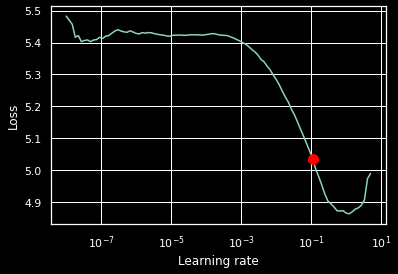

In [11]:
# Run learning rate finder
lr_finder = trainer.tuner.lr_find(mnistadd_model, mnistadd_dataset, max_lr=5)

# Plot with
fig = lr_finder.plot(suggest=True)
fig.show()

In [12]:
# Pick point based on plot, or get suggestion
new_lr = lr_finder.suggestion()

print(f'lr finder suggested lr: {new_lr}')

# update hparams of the model
mnistadd_model.hparams.lr = new_lr

lr finder suggested lr: 0.11121559854929848


In [13]:
# Train the model ⚡
trainer.fit(mnistadd_model, mnistadd_dataset)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type             | Params
-------------------------------------------------------
0 | mnist_base        | MNISTModel       | 9.9 K 
1 | prefinal_layer1   | Sequential       | 1.9 K 
2 | prefinal_layer2   | Sequential       | 3.7 K 
3 | mnist_final_layer | Sequential       | 600   
4 | adder_final_layer | Sequential       | 1.1 K 
5 | loss              | CrossEntropyLoss | 0     
-------------------------------------------------------
17.3 K    Trainable params
0         Non-trainable params
17.3 K    Total params
0.069     Total estimated model params size (MB)


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: SWA is currently only supported every epoch. Found {'scheduler': <torch.optim.lr_scheduler.OneCycleLR object at 0x7fda89545850>, 'name': 'learning_rate', 'interval': 'step', 'frequency': 1, 'reduce_on_plateau': False, 'monitor': None, 'strict': True, 'opt_idx': None}
  warnings.warn(*args, **kwargs)
Swapping scheduler <torch.optim.lr_scheduler.OneCycleLR object at 0x7fda89545850> for <torch.optim.swa_utils.SWALR object at 0x7fd9ff5da5d0>


In [14]:
trainer.test()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'adder_acc': 0.9933894276618958,
 'mnist_acc': 0.9937900900840759,
 'total_acc': 0.9873031377792358,
 'val_loss': 0.05492978170514107}
--------------------------------------------------------------------------------


[{'adder_acc': 0.9933894276618958,
  'mnist_acc': 0.9937900900840759,
  'total_acc': 0.9873031377792358,
  'val_loss': 0.05492978170514107}]

In [15]:
def infer_and_plot_output(sample_data, model):
    (mnist_img, adder_num), (mnist_target, adder_target) = sample_data
    
    with torch.no_grad():
        mnist_pred, adder_pred = model(mnist_img, adder_num)
        mnist_pred, adder_pred = torch.argmax(mnist_pred, dim=1), torch.argmax(adder_pred, dim=1)

    num_images = 25
    fig = plt.figure(figsize=(12, 15))

    assert len(mnist_img[0] >= 25), "need atleast 25 images in `sample_data`"

    fig.suptitle('MNIST Adder')

    for idx in range(0, 25):

        image = mnist_img[idx].cpu().numpy()
        add_num = adder_num[idx].cpu().item()
        image_target = mnist_target[idx].cpu().item()
        add_target = adder_target[idx].cpu().item()
        image_pred = mnist_pred[idx].cpu().item()
        add_pred = adder_pred[idx].cpu().item()

        isvalid = (image_target == image_pred) and (add_target == add_pred)
        isvalid = str(isvalid).upper()

        ax = fig.add_subplot(5, 5, idx+1)
        ax.axis('off')
        ax.imshow(mnist_img[idx].squeeze())
        ax.set_title(f'target: {image_target} + {add_num} = {add_target}\npred: {image_pred} + {add_num} = {add_pred}\nValid: {isvalid}')

    plt.show()

In [16]:
test_data = MNISTRandAdderDataModule(batch_size=25).test_dataloader()
data_iter = iter(test_data)

In [17]:
dp = next(data_iter)

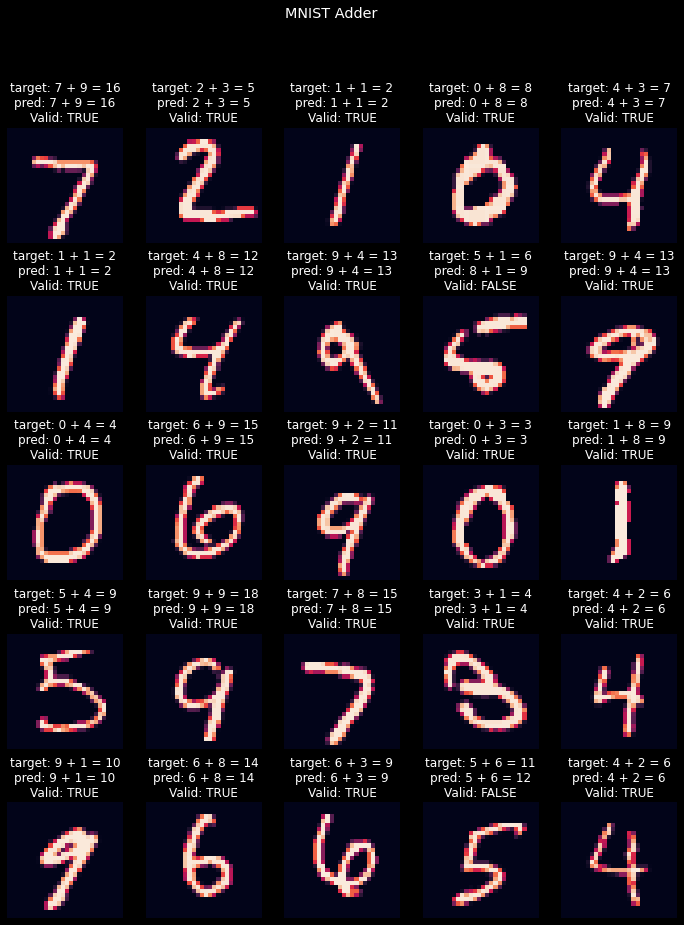

In [18]:
infer_and_plot_output(dp, mnistadd_model)

In [19]:
dp = next(data_iter)

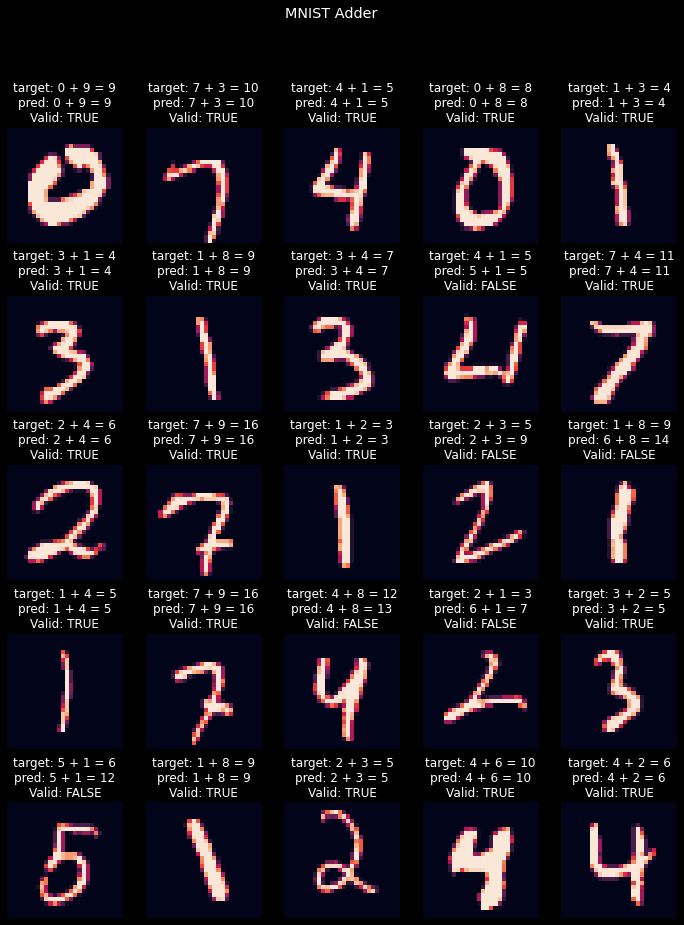

In [20]:
infer_and_plot_output(dp, mnistadd_model)